# Hamiltonian Monte Carlo with leapfrog

Scalar version: https://github.com/genkuroki/public/blob/main/0018/HMC%20leapfrog.ipynb

In [1]:
module My

using LinearAlgebra
using ConcreteStructs: @concrete
using ForwardDiff: gradient
using Parameters: @unpack
using Random: default_rng, randn!
using StaticArrays

@concrete struct LFProblem{dim} ϕ; H; F; dt; nsteps end

"""ϕ should be a potential function."""
function LFProblem(dim, ϕ; dt = 1.0, nsteps = 40)
    H(x, v, param) = dot(v, v)/2 + ϕ(x, param)
    F(x, param) = -gradient(x -> ϕ(x, param), x)
    LFProblem{dim}(ϕ, H, F, dt, nsteps)
end

"""Numerically solve Hamilton's equation of motion with leapfrog method"""
function solve(lf::LFProblem, x, v, param)
    @unpack F, dt, nsteps = lf
    v = v + F(x, param)*dt/2
    x = x + v*dt
    for _ in 2:nsteps
        v = v + F(x, param)*dt
        x = x + v*dt
    end
    v = v + F(x, param)*dt/2
    x, v
end

@inline function _update!(lf::LFProblem{dim}, x, vtmp, param, rng) where dim
    @unpack H = lf
    v = SVector{dim}(randn!(rng, vtmp))
    xnew, vnew = solve(lf, x, v, param)
    dH = H(xnew, vnew, param) - H(x, v, param)
    alpha = min(1, exp(-dH))
    rand(rng) ≤ alpha ? xnew : x
end

"""Hamiltonian Monte Carlo"""
function HMC(lf::LFProblem{dim}, param = nothing;
        niters = 10^5, thin = 1, burnin = 0, rng = default_rng(),
        init = SVector{dim}(randn(rng, dim))) where dim
    vtmp = MVector{dim}(zeros(eltype(init), dim))
    x = init
    for _ in 1:burnin
        x = _update!(lf, x, vtmp, param, rng)
    end
    sample = Vector{typeof(init)}(undef, niters)
    for i in 1:niters
        for _ in 1:thin
            x = _update!(lf, x, vtmp, param, rng)
        end
        @inbounds sample[i] = x
    end
    sample
end

end

Main.My

In [2]:
using Plots
using BenchmarkTools
using StaticArrays
using LinearAlgebra
using KernelDensity
using Statistics
using QuadGK
using Distributions

## 2-dimensional normal distribution

In [3]:
A = @SMatrix [
     1  1/2
    1/2  1
]
param = (; A = A)
ϕ(x, param) = dot(x, param.A, x)/2
lf = My.LFProblem(2, ϕ)

Main.My.LFProblem{2, typeof(ϕ), Main.My.var"#H#3"{typeof(ϕ)}, Main.My.var"#F#4"{typeof(ϕ)}, Float64, Int64}(ϕ, Main.My.var"#H#3"{typeof(ϕ)}(ϕ), Main.My.var"#F#4"{typeof(ϕ)}(ϕ), 1.0, 40)

In [4]:
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param);

  0.789205 seconds (2.01 M allocations: 125.546 MiB, 3.70% gc time, 92.90% compilation time)
  0.054953 seconds (4 allocations: 1.526 MiB)
  0.055677 seconds (4 allocations: 1.526 MiB)


In [5]:
@btime My.HMC($lf, $param);

  52.897 ms (4 allocations: 1.53 MiB)


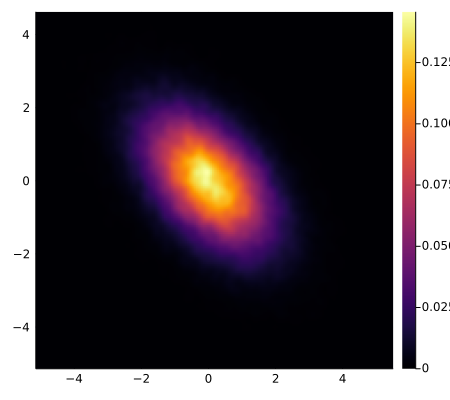

In [6]:
X, Y = first.(sample), last.(sample)
d = InterpKDE(kde((X, Y)))
x, y = range(extrema(X)...; length=201), range(extrema(Y)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400))

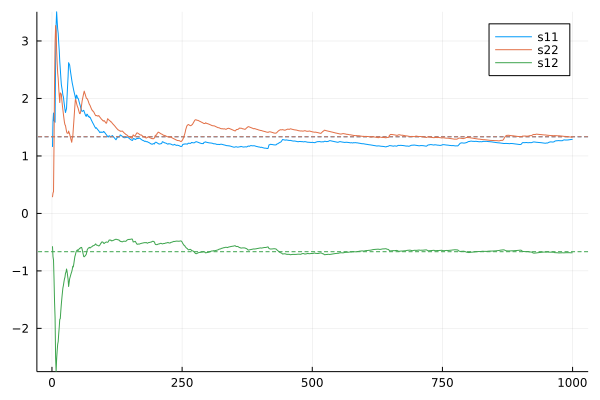

In [7]:
f(n) = mean(x -> x*x', @view sample[1:n])

n = 1:1000
S = f.(n)
S11 = (S -> S[1,1]).(S)
S22 = (S -> S[2,2]).(S)
S12 = (S -> S[1,2]).(S)

ymin = min(-1.5, minimum(S11), minimum(S22), minimum(S12))
ymax = max(2.5, maximum(S11), maximum(S22), maximum(S12))

plot(ylim = (ymin, ymax))
plot!(S11; label="s11", c=1)
hline!([inv(A)[1,1]]; label="", c=1, ls=:dash)
plot!(S22; label="s22", c=2)
hline!([inv(A)[2,2]]; label="", c=2, ls=:dash)
plot!(S12; label="s12", c=3)
hline!([inv(A)[1,2]]; label="", c=3, ls=:dash)

## φ(x) = a(x - 1)²

  0.240906 seconds (580.33 k allocations: 37.047 MiB, 5.30% gc time, 63.87% compilation time)
  0.087917 seconds (14 allocations: 1.526 MiB)
  0.091520 seconds (14 allocations: 1.526 MiB)
  0.090436 seconds (14 allocations: 1.526 MiB)
  0.089611 seconds (14 allocations: 1.526 MiB)
  0.089203 seconds (14 allocations: 1.526 MiB)


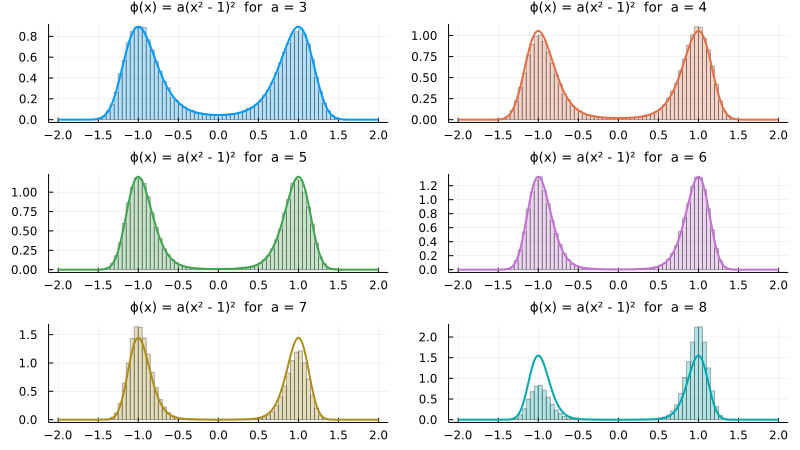

In [8]:
ϕ4(x, a) = a * (x[1]^2 - 1)^2
a = [3, 4, 5, 6, 7, 8]
XX = Vector{Float64}[]
ZZ = Float64[]
PP = []
for i in eachindex(a)
    Z = quadgk(x -> exp(-ϕ4((x,), a[i])), -Inf, Inf)[1]
    push!(ZZ, Z)
    lf = My.LFProblem(1, ϕ4; dt = 0.05, nsteps = 100)
    @time X = first.(My.HMC(lf, a[i]))
    flush(stdout)
    push!(XX, X)
    P = plot()
    histogram!(X; norm=true, alpha=0.3, label="HMC LF sample", bin=100, c=i)
    plot!(x -> exp(-ϕ4(x, a[i]))/Z, -2, 2; label="exp(-ϕ2(x))/Z", lw=2, c=i)
    plot!(; legend=false, xtick=-2:0.5:2)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(PP, P)
end
plot(PP...; size=(800, 450), layout=(3, 2))

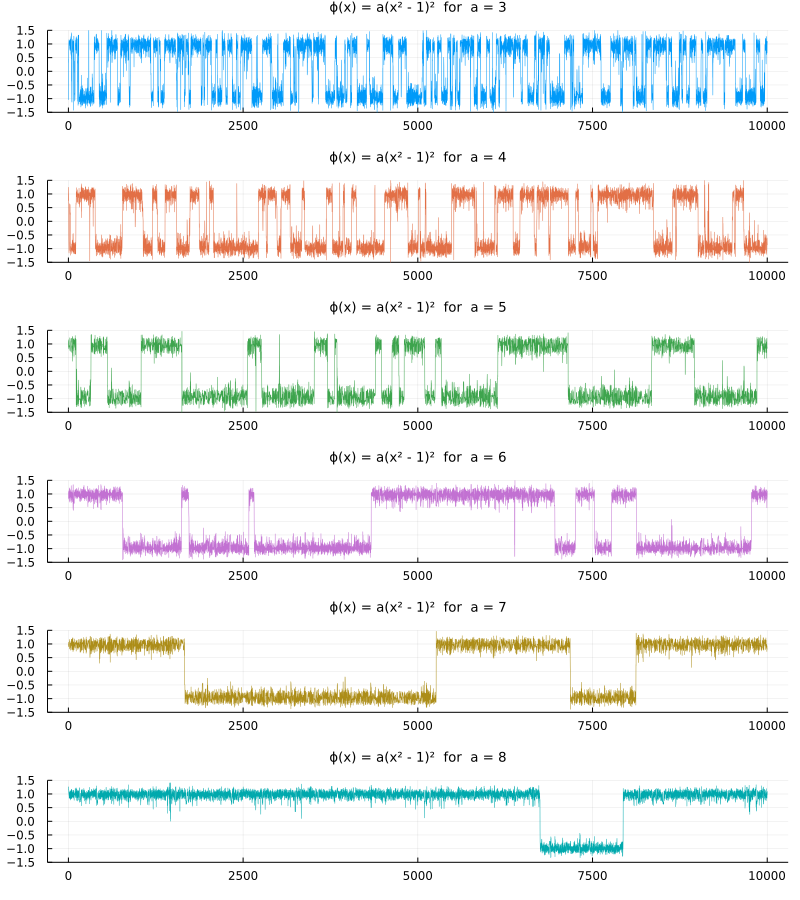

In [9]:
QQ = []
for i in eachindex(a)
    Q = plot(XX[i][1:10000]; ylim=(-1.5, 1.5), label="", c=i, lw=0.5)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(QQ, Q)
end
plot(QQ...; size=(800, 900), layout=(length(a), 1))

## Baysian inference for a sample of the standard normal distribution

In [10]:
n = 10
sample_normal = randn(n)
f(y, m, s) = (y - m)^2/(2s^2) + log(s)
negloglik(w, sample) = sum(y -> f(y, w[1], exp(w[2])), sample)
lf = My.LFProblem(2, negloglik; dt = 0.1, nsteps = 30)

Main.My.LFProblem{2, typeof(negloglik), Main.My.var"#H#3"{typeof(negloglik)}, Main.My.var"#F#4"{typeof(negloglik)}, Float64, Int64}(negloglik, Main.My.var"#H#3"{typeof(negloglik)}(negloglik), Main.My.var"#F#4"{typeof(negloglik)}(negloglik), 0.1, 30)

In [11]:
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))

  0.872137 seconds (513.51 k allocations: 31.756 MiB, 21.16% compilation time)
  0.691985 seconds (3 allocations: 1.526 MiB)
  0.697130 seconds (3 allocations: 1.526 MiB)


100000-element Vector{SVector{2, Float64}}:
 [0.5268882183577793, -0.014792710464466174]
 [-0.14173849375881845, -0.0782411314842909]
 [0.306953453127409, -0.08174844556392502]
 [0.3574020754051199, -0.15121747541406946]
 [0.18835163673240063, 0.0013491758051362157]
 [0.0410278699142858, -0.14528543032451524]
 [0.18643415174398334, -0.016843759961070084]
 [0.02145732745774548, -0.061324400451824836]
 [0.17856790643423004, -0.09975850853256771]
 [0.008623228806134843, -0.2648926429698939]
 [0.16419867147664774, -0.23287966987457537]
 [0.06588560714437879, -0.1991413913290456]
 [0.13580940773768818, -0.12930622994699498]
 ⋮
 [0.5699696080826012, -0.044848302757773253]
 [-0.1875752130469974, 0.04365041104824471]
 [0.3381647282089512, -0.12540545581749443]
 [-0.1352352794844729, -0.06371644488144099]
 [0.24478189738601358, 0.14534106499243934]
 [0.3175405166377571, 0.23616267383036899]
 [0.3175405166377571, 0.23616267383036899]
 [-0.046520371315570144, 0.39089920417146207]
 [0.863336608978

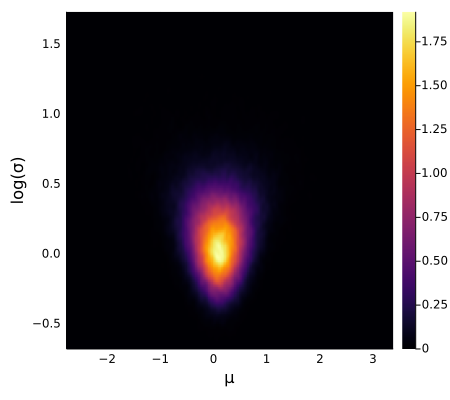

In [12]:
m, logs = first.(sample), last.(sample)
d = InterpKDE(kde((m, logs)))
x, y = range(extrema(m)...; length=201), range(extrema(logs)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400), xlabel="μ", ylabel="log(σ)")